# Example: Electricity price forecasting with ARX models

This notebook demonstrates how to use the electricity pricing forecasting models.

## 1. Setup

First, let's load the processed electricity and forecast data.

In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
plt.style.use('seaborn-v0_8-colorblind')

from electricity_pricing.data.loading import load_and_merge_datasets

# Load and merge data using the data loading pipeline
base_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed")
df = load_and_merge_datasets(
    electricity_path=os.path.join(base_dir, "electricity_data.csv"),
    forecast_path=os.path.join(base_dir, "forecast_data.csv"),
    date_range=(datetime.date(2021, 1, 2), datetime.date(2024, 12, 31)),
    validate=True,
    verbose=False
)

# Create timezone-aware timestamps and set them as the index
df['timestamp_utc'] = (df['SETTLEMENT_DATE'] + pd.to_timedelta((df['SETTLEMENT_PERIOD'] - 1) * 30, unit='m')).dt.tz_localize('UTC')
df['DATETIME'] = df['timestamp_utc'].dt.tz_convert('Europe/London')
df.drop(columns=['timestamp_utc'], inplace=True)
df = df.sort_values(by='DATETIME', ascending=True).reset_index(drop=True)
df.set_index('DATETIME', inplace=True)

print(f"Data loaded: {len(df)} samples from {df.index[0]} to {df.index[-1]}")
df.head()

Data loaded: 67920 samples from 2021-01-02 00:00:00+00:00 to 2024-12-30 23:30:00+00:00


,SETTLEMENT_DATE,SETTLEMENT_PERIOD,BIOMASS,GAS,COAL,OIL,NUCLEAR,SOLAR,WIND,OTHER,...,naturalGasPrice,DEMAND_FORECAST,EMBEDDED_WIND_FORECAST,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_FORECAST,EMBEDDED_SOLAR_CAPACITY,Forecast_Datetime,DATETIME_GMT,WIND_CAPACITY,WIND_FORECAST
DATETIME,,,,,,,,,,,,,,,,,,,,,
2021-01-02 00:00:00+00:00,2021-01-02,1,2466.0,11176.0,0.0,0.0,5923.0,0.0,3817.661,570.0,...,19.578,26422.0,879,6527,0,13082,2021-01-01 08:12:00+00:00,2021-01-02 00:30:00+00:00,15729,2383
2021-01-02 00:30:00+00:00,2021-01-02,2,2467.0,11235.0,0.0,0.0,5929.0,0.0,3989.388,549.0,...,19.578,26622.0,867,6527,0,13082,2021-01-01 08:12:00+00:00,2021-01-02 01:00:00+00:00,15729,2382
2021-01-02 01:00:00+00:00,2021-01-02,3,2456.0,11461.0,0.0,0.0,5919.0,0.0,3912.158,652.0,...,19.578,26229.0,867,6527,0,13082,2021-01-01 08:12:00+00:00,2021-01-02 01:30:00+00:00,15729,2398
2021-01-02 01:30:00+00:00,2021-01-02,4,2463.0,10885.0,0.0,0.0,5932.0,0.0,3891.883,524.0,...,19.578,25836.0,863,6527,0,13082,2021-01-01 08:12:00+00:00,2021-01-02 02:00:00+00:00,15729,2429
2021-01-02 02:00:00+00:00,2021-01-02,5,2481.0,10643.0,0.0,0.0,5928.0,0.0,3907.977,525.0,...,19.578,25443.0,863,6527,0,13082,2021-01-01 08:12:00+00:00,2021-01-02 02:30:00+00:00,15729,2474


## 2. Feature engineering

Create features for the ARX model:

**Autoregressive features:**
- Lagged prices from previous settlement periods (1, 2, 3 periods ago)
- Lagged prices from same period on previous days (1 day, 7 days ago)

**Exogenous variables:**
- Suppressed demand (demand forecast - embedded generation)
- Wind generation forecast
- Gas prices (lagged 2 days)

**Temporal features:**
- Holiday indicator
- Weekend indicator

In [18]:
from electricity_pricing.features import is_holiday, is_weekend, add_intercept
from electricity_pricing.utils import timeshift

df['SETTLEMENT_DATE'] = pd.to_datetime(df['SETTLEMENT_DATE'])

# Autoregressive features: day lags (handles daylight savings correctly)
for dlag in [1, 7]:
    df[f'price_lag_day_{dlag}'] = timeshift(df['marketIndexPrice'], pd.Timedelta(days=-dlag))

# Exogenous variables
df['suppressed_demand'] = df['DEMAND_FORECAST'] - df['EMBEDDED_WIND_FORECAST'] - df['EMBEDDED_SOLAR_FORECAST']
df['wind_gen'] = df['WIND_FORECAST']
df['gas_price'] = timeshift(df['naturalGasPrice'], pd.Timedelta(days=-2))

# Temporal features
df['is_holiday'] = is_holiday(df, 'SETTLEMENT_DATE', country='GB')
df['is_weekend'] = is_weekend(df, 'SETTLEMENT_DATE')

# Intercept for linear models
add_intercept(df, column_name='intercept', inplace=True)

# Drop any rows that have NaNs in the exogenous variables (usually due to lagging)
df = df.ffill(limit=3)  # only fill up to 3 consecutive NaNs
df = df.dropna()

# Define features and target
exog_cols = ['price_lag_day_1', 'price_lag_day_7', 'suppressed_demand', 'wind_gen', 
             'gas_price', 'is_holiday', 'is_weekend', 'intercept']
exog = df[exog_cols].copy()
endog = df['marketIndexPrice'].copy()

print(f"Features created: {exog.shape}")
print(f"Feature names: {exog_cols}")

Features created: (63864, 8)
Feature names: ['price_lag_day_1', 'price_lag_day_7', 'suppressed_demand', 'wind_gen', 'gas_price', 'is_holiday', 'is_weekend', 'intercept']


## 3. Train-Test split

Split data into training (2021-2024) and test (2024) sets.

In [19]:
from electricity_pricing.utils import train_test_split

# Define train and test periods
train_range = [pd.to_datetime("2021-02-01").tz_localize("Europe/London"),
               pd.to_datetime("2024-02-01").tz_localize("Europe/London")]
test_range = [pd.to_datetime("2024-02-02").tz_localize("Europe/London"),
              pd.to_datetime("2024-12-01").tz_localize("Europe/London")]

exog_train, exog_test = train_test_split(exog, train_range, test_range)
endog_train, endog_test = train_test_split(endog, train_range, test_range)

print(f"Training set: {exog_train.shape[0]} samples")
print(f"Test set: {exog_test.shape[0]} samples")

Training set: 46912 samples
Test set: 14362 samples


## 4. Training

Train multiple ARX models with different regressors.

### 4.1 Linear ARX Model (OLS)

Train a linear ARX model using ordinary least squares regression.

In [20]:
from electricity_pricing.models import ARXModel
from electricity_pricing.regressors import LinearRegression

# Create and train ARX model with 3 settlement period lags
model_ols = ARXModel(lags=[1, 2, 3], regressor=LinearRegression())
model_ols.fit(endog_train, exog_train)

# Display coefficients
feature_names = [f'price_lag_sp_{lag}' for lag in model_ols.lags] + exog_cols
print("Linear ARX Model Coefficients:")
for feature, coef in zip(feature_names, model_ols.get_params()):
    print(f"  {feature:20s} = {coef:8.4f}")

Linear ARX Model Coefficients:
  price_lag_sp_1       =   1.0491
  price_lag_sp_2       =  -0.0454
  price_lag_sp_3       =  -0.0927
  price_lag_day_1      =   0.0335
  price_lag_day_7      =   0.0172
  suppressed_demand    =   0.0001
  wind_gen             =  -0.0003
  gas_price            =   0.0843
  is_holiday           =  -1.8649
  is_weekend           =  -0.9315
  intercept            =   1.8913


### 4.2 Ridge and Lasso regression

Train regularised models that can help to prevent overfitting.

In [21]:
from sklearn.linear_model import Ridge, Lasso

# Ridge regression (L2 regularisation)
model_ridge = ARXModel(lags=[1, 2, 3], regressor=Ridge(alpha=1.0))
model_ridge.fit(endog_train, exog_train)

# Lasso regression (L1 regularisation)
model_lasso = ARXModel(lags=[1, 2, 3], regressor=Lasso(alpha=0.1, max_iter=10000))
model_lasso.fit(endog_train, exog_train)

print("Ridge and Lasso models trained successfully")

Ridge and Lasso models trained successfully


### 4.3 XGBoost (non-linear regression)

Train a gradient boosting model to capture non-linear relationships.

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

model_xgb = ARXModel(
    lags=[1, 2, 3],
    regressor=GradientBoostingRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.9,
        random_state=42
    )
)
model_xgb.fit(endog_train, exog_train)

print("XGBoost model trained successfully")

XGBoost model trained successfully


## 5. Evaluation & Visualisation

In [23]:
# Evaluate all models on the test set using day-ahead forecasting
from electricity_pricing.forecast import forecast_day_ahead
import electricity_pricing.evaluation_metrics as metrics

def evaluate_model(y_true, y_pred, model_name):
    """Evaluate a model and return metrics."""
    return {
        'Model': model_name,
        'RMSE (£/MWh)': metrics.rmse(y_true, y_pred),
        'MAE (£/MWh)': metrics.mae(y_true, y_pred),
        'MAPE (%)': metrics.mape(y_true, y_pred),
        'R²': metrics.r2_score(y_true, y_pred)
    }

# Generate day-ahead forecasts for all models
print("Generating day-ahead forecasts...")
forecast_ols, actuals = forecast_day_ahead(model_ols, endog_test, exog_test, skip_days=2)
forecast_ridge, _ = forecast_day_ahead(model_ridge, endog_test, exog_test, skip_days=2)
forecast_lasso, _ = forecast_day_ahead(model_lasso, endog_test, exog_test, skip_days=2)
forecast_xgb, _ = forecast_day_ahead(model_xgb, endog_test, exog_test, skip_days=2)

# Evaluate all models
results = [
    evaluate_model(actuals, forecast_ols, 'Linear OLS'),
    evaluate_model(actuals, forecast_ridge, 'Ridge (alpha=1.0)'),
    evaluate_model(actuals, forecast_lasso, 'Lasso (alpha=0.1)'),
    evaluate_model(actuals, forecast_xgb, 'XGBoost')
]

# Display results
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("MODEL COMPARISON - Test Set Performance (Day-Ahead Forecasts)")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

Generating day-ahead forecasts...

MODEL COMPARISON - Test Set Performance (Day-Ahead Forecasts)
            Model  RMSE (£/MWh)  MAE (£/MWh)   MAPE (%)       R²
       Linear OLS     24.455700    18.283378 153.397734 0.316774
Ridge (alpha=1.0)     24.455544    18.283266 153.395084 0.316783
Lasso (alpha=0.1)     24.399232    18.193812 150.818727 0.319926
          XGBoost     23.454180    16.219121 176.946944 0.371588


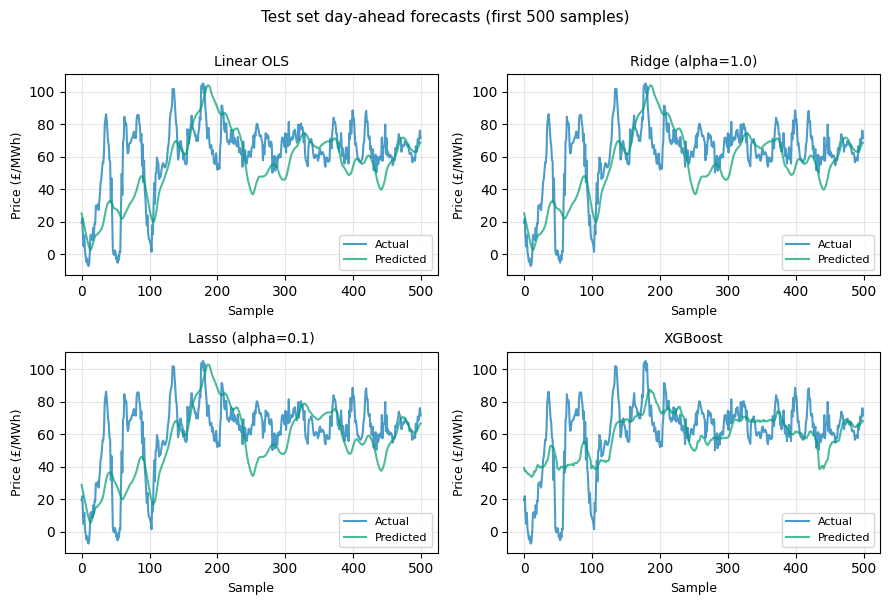

In [24]:
# Generate predictions - plot first 500 samples
fig, axes = plt.subplots(2, 2, figsize=(9, 6), layout='tight')
axes = axes.flatten()

models_to_plot = [
    (forecast_ols, 'Linear OLS'),
    (forecast_ridge, 'Ridge (alpha=1.0)'),
    (forecast_lasso, 'Lasso (alpha=0.1)'),
    (forecast_xgb, 'XGBoost')
]

for ax, (y_pred, name) in zip(axes, models_to_plot):
    ax.plot(actuals.values[:500], label='Actual', alpha=0.7, linewidth=1.5)
    ax.plot(y_pred.values[:500], label='Predicted', alpha=0.7, linewidth=1.5)
    ax.set_xlabel('Sample', fontsize=9)
    ax.set_ylabel('Price (£/MWh)', fontsize=9)
    ax.set_title(name, fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Test set day-ahead forecasts (first 500 samples)', fontsize=11, y=1.00)
plt.show()

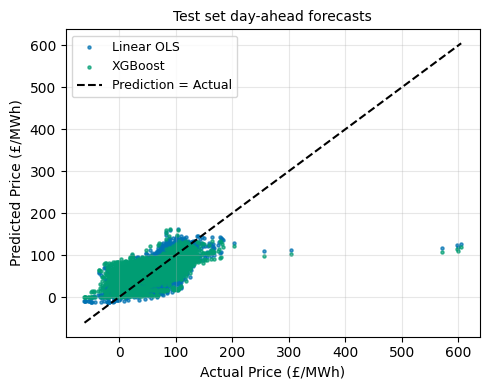

In [25]:
# Scatter plot showing predicted vs actual prices
fig, ax = plt.subplots(figsize=(5, 4), layout='tight')

ax.scatter(actuals, forecast_ols, alpha=0.7, s=5, label='Linear OLS')
ax.scatter(actuals, forecast_xgb, alpha=0.7, s=5, label='XGBoost')
ax.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'k--', linewidth=1.5, label='Prediction = Actual')

ax.set_xlabel('Actual Price (£/MWh)', fontsize=10)
ax.set_ylabel('Predicted Price (£/MWh)', fontsize=10)
ax.set_title('Test set day-ahead forecasts', fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.show()

Display sample predictions for the third forecasted day:


Sample Predictions (Forecasted Day: 2024-02-04):
                     Time  Actual Price  Predicted Price (OLS)  Error (OLS)  Predicted Price (XGB)  Error (XGB)
2024-02-04 00:00:00+00:00         19.43              25.149817     5.719817              39.275611    19.845611
2024-02-04 00:30:00+00:00         21.90              23.155940     1.255940              37.367851    15.467851
2024-02-04 01:00:00+00:00         10.62              21.174781    10.554781              37.645182    27.025182
2024-02-04 01:30:00+00:00          4.81              18.911466    14.101466              37.250543    32.440543
2024-02-04 02:00:00+00:00         11.69              17.020832     5.330832              36.240437    24.550437
2024-02-04 02:30:00+00:00          1.50              15.052602    13.552602              36.179606    34.679606
2024-02-04 03:00:00+00:00         -1.18              13.067940    14.247940              35.304252    36.484252
2024-02-04 03:30:00+00:00         -4.70              1

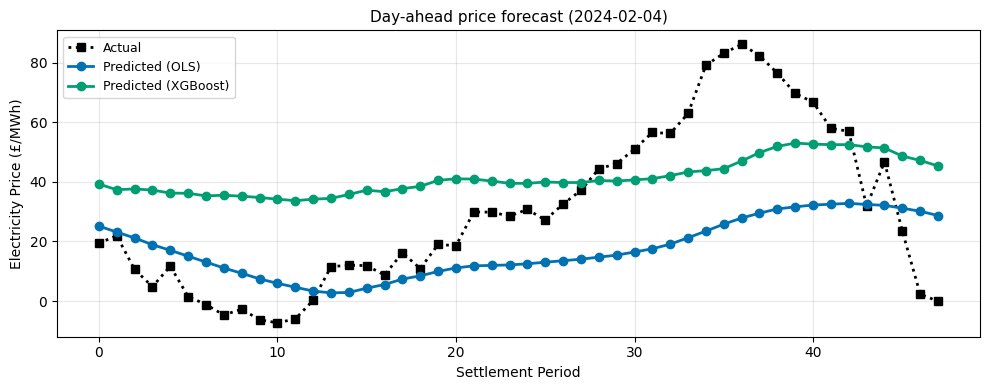

In [26]:
day = 2
day_date = actuals.index.date[day]
day_mask = actuals.index.date == day_date
day_indices = np.where(day_mask)[0]

sample_times = actuals.index[day_indices]
actual_prices = actuals.iloc[day_indices].values
pred_ols = forecast_ols.iloc[day_indices].values
pred_xgb = forecast_xgb.iloc[day_indices].values

results_sample = pd.DataFrame({
    'Time': sample_times,
    'Actual Price': actual_prices,
    'Predicted Price (OLS)': pred_ols,
    'Error (OLS)': pred_ols - actual_prices,
    'Predicted Price (XGB)': pred_xgb,
    'Error (XGB)': pred_xgb - actual_prices
})

print(f"\nSample Predictions (Forecasted Day: {day_date}):")
print(results_sample.head(10).to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 4), layout='tight')
n_periods = len(day_indices)
ax.plot(range(n_periods), actual_prices, marker='s', ls=':', color='black', label='Actual', linewidth=2)
ax.plot(range(n_periods), pred_ols, marker='o', label='Predicted (OLS)', linewidth=2)
ax.plot(range(n_periods), pred_xgb, marker='o', label='Predicted (XGBoost)', linewidth=2)
ax.set_xlabel('Settlement Period', fontsize=10)
ax.set_ylabel('Electricity Price (£/MWh)', fontsize=10)
ax.set_title(f'Day-ahead price forecast ({day_date})', fontsize=11)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.show()